# Home Credit 2024

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import all required dependencies

In [2]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import joblib
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# Load Data

Depth values:

* depth=0 - These are static features directly tied to a specific *case_id*.
* depth=1 - Each *case_id* has an associated historical record, indexed by *num_group1*.
* depth=2 - Each *case_id* has an associated historical record, indexed by both *num_group1* and *num_group2*.

## Configure input paths


In [3]:
class CFG:
    root_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/")
    train_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train")
    test_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test")

## Load feature definitions

In [ ]:
feature_definitions_df = pd.read_csv(CFG.root_dir / "feature_definitions.csv")
display(feature_definitions_df)
pd.reset_option("display.max_rows", 0)

## Data Collection and Preprocessing using Pipeline

In [5]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

## Aggregate data from different datasets

In [6]:
class Aggregator:
    num_aggregators = [pl.max, pl.min, pl.first, pl.last, pl.mean]
    str_aggregators = [pl.max, pl.min, pl.first, pl.last] # n_unique
    group_aggregators = [pl.max, pl.min, pl.first, pl.last]
    
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_all = []
        for method in Aggregator.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]
            expr_all += expr

        return expr_all

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]
        expr_all = []
        for method in Aggregator.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_all = []
        for method in Aggregator.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr
            
        expr_mode = [
            pl.col(col)
            .drop_nulls()
            .mode()
            .first()
            .alias(f"mode_{col}")
            for col in cols
        ]

        return expr_all + expr_mode

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_all = []
        for method in Aggregator.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_all = []
        for method in Aggregator.group_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr
            
#         if len(cols) > 0:
#             method = pl.count
#             expr = [method(col).alias(f"{method.__name__}_{col}") for col in [cols[0]]]
#             expr_all += expr

        return expr_all

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

## Read files with previous function application

In [7]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_table_dtypes))
        
    df = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

## Feature Engineering

In [8]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [9]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data

In [10]:
def reduce_mem_usage(df, float16_as32=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)                    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Prepare Dataframe

In [11]:
def prepare_df(data_dir, cat_cols=None, mode="train", display_store=False, train_cols=[]):
    print("Collecting data...")
    data_store = {
        "df_base": read_file(data_dir / f"{mode}_base.parquet"),
        "depth_0": [
            read_file(data_dir / f"{mode}_static_cb_0.parquet"),
            read_files(data_dir / f"{mode}_static_0_*.parquet"),
        ],
        "depth_1": [
            read_files(data_dir / f"{mode}_applprev_1_*.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_a_1.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_b_1.parquet", 1),
            read_file(data_dir / f"{mode}_tax_registry_c_1.parquet", 1),
            read_file(data_dir / f"{mode}_credit_bureau_b_1.parquet", 1),
            read_file(data_dir / f"{mode}_other_1.parquet", 1),
            read_file(data_dir / f"{mode}_person_1.parquet", 1),
            read_file(data_dir / f"{mode}_deposit_1.parquet", 1),
            read_file(data_dir / f"{mode}_debitcard_1.parquet", 1),
        ],
        "depth_2": [
            read_file(data_dir / f"{mode}_credit_bureau_b_2.parquet", 2),
        ]
    }
    if display_store:
        display(data_store)
    
    print("Feature engeneering...")
    feats_df = feature_eng(**data_store)
    print("  feats_df shape:\t", feats_df.shape)
    
    del data_store
    gc.collect()
    
    print("Filter cols...")
    if mode == "train":
        feats_df = feats_df.pipe(Pipeline.filter_cols)
    else:
        train_cols = feats_df.columns if len(train_cols) == 0 else train_cols
        feats_df = feats_df.select([col for col in train_cols if col != "target"])
    print("  feats_df shape:\t", feats_df.shape)
    
    print("Convert to pandas...")
    feats_df = to_pandas(feats_df, cat_cols)
    return feats_df

### Configure train data

In [12]:
train_df = prepare_df(CFG.train_dir)
cat_cols = list(train_df.select_dtypes("category").columns)

Feature engeneering...
  feats_df shape:	 (1526659, 927)
Filter cols...
  feats_df shape:	 (1526659, 516)
Convert to pandas...


In [ ]:
display(train_df)

In [ ]:
display(cat_cols)

### Configure test data

In [15]:
test_df = prepare_df(CFG.test_dir, cat_cols=cat_cols, mode="test", train_cols=train_df.columns)

  feats_df shape:	 (10, 926)
Filter cols...
  feats_df shape:	 (10, 515)
Convert to pandas...


In [ ]:
display(test_df)

### Reduce memory usage and save

In [17]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage after optimization is: 2357.21 MB
Decreased by 48.5%
Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.04 MB
Decreased by 15.4%


In [ ]:
train_df.to_parquet("train_full.parquet")

# Exploration

In [18]:
print("Train is duplicated:\t", train_df["case_id"].duplicated().any())
print("Train Week Range:\t", (train_df["WEEK_NUM"].min(), train_df["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", test_df["case_id"].duplicated().any())
print("Test Week Range:\t", (test_df["WEEK_NUM"].min(), test_df["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (92, 92)


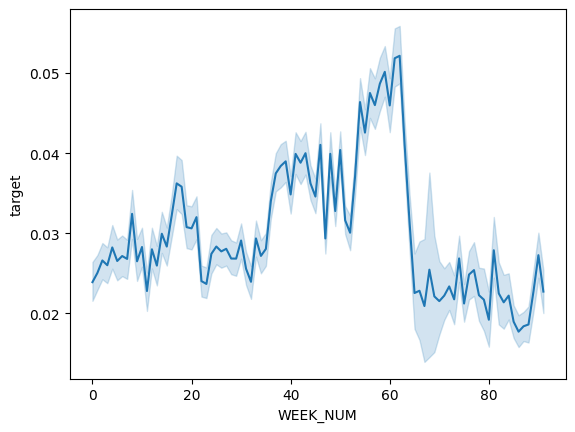

In [19]:
sns.lineplot(
        data=train_df,
        x="WEEK_NUM",
        y="target",
)
plt.show()

### Features - Missed values - Unique values

In [20]:
def dataframe_summary(dataframe):
    summary = dict()
    for col in dataframe.columns:
        missed_val = dataframe[col].isna().sum()
        summary[col] = {'missed': missed_val, 
                        'missed_percentage': missed_val*100 / dataframe.shape[0], 
                        'unique': dataframe[col].unique().__len__(),
                        'type': dataframe[col].dtype} 
    return pd.DataFrame.from_dict(summary)

train_df_summary = dataframe_summary(train_df).T
test_df_summary = dataframe_summary(test_df).T

### Now we have summary for our dataframes with:
* *missed*, missed values of the feature
* *missed_percentage*, percent of missed values in the column
* *unique*, number of unique values
* *type*, datatype of the feature

In [21]:
train_df_summary.T

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_60

In [ ]:
train_df_summary[(train_df_summary.missed_percentage < 5) & (train_df_summary.type == 'category')].T

,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,credtype_322L,disbursementtype_67L,inittransactioncode_186L,lastapprcommoditycat_1041M,lastcancelreason_561M,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectreason_759M,lastrejectreasonclient_4145040M,paytype1st_925L,paytype_783L,twobodfilling_608L,max_education_927M,max_empladdr_district_926M,max_empladdr_zipcode_114M,max_language1_981M,min_education_927M,min_language1_981M,first_education_927M,first_language1_981M,last_education_927M,last_empladdr_district_926M,last_empladdr_zipcode_114M,last_language1_981M,mode_education_927M,mode_language1_981M,max_contaddr_matchlist_1032L,max_contaddr_smempladdr_334L,max_incometype_1044T,max_role_1084L,max_safeguarantyflag_411L,max_sex_738L,max_type_25L,min_contaddr_matchlist_1032L,min_contaddr_smempladdr_334L,min_incometype_1044T,min_safeguarantyflag_411L,min_sex_738L,min_type_25L,first_contaddr_matchlist_1032L,first_contaddr_smempladdr_334L,first_incometype_1044T,first_role_1084L,first_safeguarantyflag_411L,first_sex_738L,first_type_25L,last_role_1084L,last_type_25L
missed,26183,26183,26183,26183,26183,1,866,1,0,0,0,0,0,0,58575,58575,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,441,441,0,0,2,0,0,441,441,0,2,0,0,441,441,0,0,2,0,0,6117,6117
missed_percentage,1.715052,1.715052,1.715052,1.715052,1.715052,0.000066,0.056725,0.000066,0.0,0.0,0.0,0.0,0.0,0.0,3.83681,3.83681,0.005961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028887,0.028887,0.0,0.0,0.000131,0.0,0.0,0.028887,0.028887,0.0,0.000131,0.0,0.0,0.028887,0.028887,0.0,0.0,0.000131,0.0,0.0,0.400679,0.400679
unique,3,6,6,7,7,4,4,4,45,74,45,187,18,14,2,2,3,6,22,24,3,6,3,6,3,6,22,24,3,6,3,2,3,9,3,3,2,5,2,3,9,3,2,5,2,3,9,2,3,2,6,4,8
type,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category


### Categorical features with large amount of unique values:
* lastapprcommoditycat_1041M - **45**
* lastcancelreason_561M - **74**
* lastrejectcommoditycat_161M - **45**
* lastrejectcommodtypec_5251769M - **187**

In [ ]:
train_df.lastapprcommoditycat_1041M.unique()

['a55475b1', 'P159_130_59', 'P21_79_33', 'P12_6_178', 'P109_133_183', ..., 'P155_91_176', 'P38_69_128', 'P93_39_173', 'P58_25_91', 'P187_21_169']
Length: 45
Categories (45, object): ['P100_96_175', 'P105_126_172', 'P109_133_183', 'P110_120_162', ..., 'P76_145_175', 'P93_39_173', 'P98_19_172', 'a55475b1']

In [ ]:
train_df.lastcancelreason_561M.unique()

['a55475b1', 'P94_109_143', 'P24_27_36', 'P85_114_140', 'P73_130_169', ..., 'P59_114_135', 'P60_96_75', 'P191_55_173', 'P204_22_168', 'P203_151_99']
Length: 74
Categories (74, object): ['P107_145_100', 'P116_157_162', 'P118_140_56', 'P118_30_169', ..., 'P98_38_170', 'P99_98_113', 'P9_82_76', 'a55475b1']

In [ ]:
train_df.lastrejectcommoditycat_161M.unique()

['a55475b1', 'P100_96_175', 'P53_45_92', 'P159_130_59', 'P21_79_33', ..., 'P181_140_94', 'P176_123_187', 'P126_161_96', 'P187_21_169', 'P58_25_91']
Length: 45
Categories (45, object): ['P100_96_175', 'P105_126_172', 'P109_133_183', 'P110_120_162', ..., 'P75_42_174', 'P76_145_175', 'P98_19_172', 'a55475b1']

In [ ]:
train_df.lastrejectcommodtypec_5251769M.unique()

['a55475b1', 'P111_89_135', 'P75_90_70', 'P5_163_186', 'P128_13_121', ..., 'P164_84_181', 'P49_58_169', 'P140_117_94', 'P28_129_133', 'P61_82_106']
Length: 187
Categories (187, object): ['P100_118_186', 'P101_97_152', 'P102_65_162', 'P103_64_162', ..., 'P98_19_172', 'P98_55_164', 'P99_150_162', 'a55475b1']

### Extra preprocessing:
* extract only features with 5% and less missed data
* replaced missed values with MEAN and MODE
* encode categorical data with less than 45 categories

In [ ]:
def fillna_n_encode(train_dataframe, test_dataframe, summary):
    
    # define numeric and categorical columns with no more than 5% missed values
    print('Defining columns...')
    num_feat = summary[(summary.missed_percentage < 5) & (summary.type != 'category')].T.columns.to_list()
    num_feat.pop(2) # remove TARGET
    cat_feat = summary[(summary.missed_percentage < 5) & (summary.type == 'category') & (summary.unique < 45)].T.columns.to_list()
    
    # concat dataframes
    train_size = train_dataframe.shape[0]
    concat_df = pd.concat([train_dataframe, test_dataframe], ignore_index=True)
    
    # fill numeric missed values with mean value for the feature
    print('Fill missed numbers...')
    concat_df[num_feat] = concat_df[num_feat].apply(lambda x: x.fillna(x.mean()),axis=0)

    # fill categorical missed values with mode value for the feature
    print('Fill missed categories...')
    concat_df[cat_feat] = concat_df[cat_feat].apply(lambda x: x.fillna(x.mode().iloc[0]),axis=0)

    # redefine dataframe with only necesary columns
    concat_df = concat_df[num_feat + cat_feat + ['target']]
    
    # convert CATEGORY data with encoder
    print('Encoding...')
    ohe = OneHotEncoder()
    ohe.fit(concat_df[cat_feat])
    temp_df = pd.DataFrame(data=ohe.transform(concat_df[cat_feat]).toarray(), columns=ohe.get_feature_names_out())
    concat_df = pd.concat([concat_df.reset_index(drop=True), temp_df], axis=1)
    
    # drop columns
    concat_df.drop(cat_feat, axis=1, inplace=True)
    print('Done!')               
    return concat_df.iloc[:train_size], concat_df.iloc[train_size:] 
    
train_df, test_df = fillna_n_encode(train_df, test_df, train_df_summary)

Defining columns...
Fill missed numbers...
Fill missed categories...
Encoding...
Done!


In [ ]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 3731.56 MB
Memory usage after optimization is: 2065.97 MB
Decreased by 44.6%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.01 MB
Decreased by 44.3%


In [39]:
test_df = test_df.drop('target', axis=1)

# Modeling

In [30]:
drop_cols = []
# drop_cols_startwith = ["std_"]
# for name_prefix in drop_cols_startwith:
#     cols_names = train_df.columns[train_df.columns.str.startswith(name_prefix)]
#     drop_cols += cols_names.to_list()
# display(drop_cols)

In [31]:
def gini_stability(base, score_col="score", w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", score_col]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", score_col]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x[score_col])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

## LGBM

In [32]:
'''
%%time
X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"] + drop_cols)
print("X shape: ", X.shape)
y = train_df["target"]
weeks = train_df["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "max_bin": 255,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []
oof_pred = np.zeros(X.shape[0])

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )
    fitted_models.append(model)
    val_pred = model.predict_proba(X_valid)[:, 1]
    oof_pred[idx_valid] = val_pred
    gc.collect()
'''

X shape:  (1526659, 354)


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.756508
[200]	valid_0's auc: 0.766305
[300]	valid_0's auc: 0.769115
[400]	valid_0's auc: 0.770704
[500]	valid_0's auc: 0.7716
[600]	valid_0's auc: 0.77205
[700]	valid_0's auc: 0.772553
[800]	valid_0's auc: 0.772977
[900]	valid_0's auc: 0.773121
[1000]	valid_0's auc: 0.773235
Did not meet early stopping. Best iteration is:
[958]	valid_0's auc: 0.773274
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.753492
[200]	valid_0's auc: 0.763236
[300]	valid_0's auc: 0.766309
[400]	valid_0's auc: 0.767918
[500]	valid_0's auc: 0.769026
[600]	valid_0's auc: 0.769905
[700]	valid_0's auc: 0.770314
[800]	valid_0's auc: 0.770717
[900]	valid_0's auc: 0.770969
[1000]	valid_0's auc: 0.77113
Did not meet early stopping. Best iteration is:
[990]	valid_0's auc: 0.771153
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.757946
[200]	valid_0's auc: 0.768186


In [33]:
'''
roc_auc_oof = roc_auc_score(y, oof_pred)
print("CV roc_auc_oof: ", roc_auc_oof)
'''

CV roc_auc_oof:  0.7750021598087322


In [34]:
'''
oof_df = train_df[["WEEK_NUM", "target"]].copy()
oof_df["pred_oof"] = oof_pred
gini_score = gini_stability(oof_df, score_col="pred_oof")
print("gini_score:\t", gini_score)
'''

gini_score:	 0.5161481209392367


In [35]:
'''
oof_models_dict = [(str(i), model) for i, model in enumerate(fitted_models)]

model = VotingClassifier(
    estimators=oof_models_dict,
    voting='soft',
)
model.estimators_ = fitted_models
model.le_ = LabelEncoder().fit(y)
model.classes_ = model.le_.classes_
'''

In [ ]:
# joblib.dump(model, "oof_model_1.pkl")

In [ ]:
# joblib.dump((train_df.columns, cat_cols, drop_cols), "train_cat_columns.pkl")

In [ ]:
# joblib.dump(oof_pred, "oof_pred.pkl")

## XGBooster (ON HOLD since require data preparation)

In [ ]:
#'''
#%%time
# X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"] + drop_cols)
print("X shape: ", X.shape)
# y = train_df["target"]
# weeks = train_df["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "booster": "dart", #  gbtee
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 8,
    "max_bin": 255,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []
oof_pred = np.zeros(X.shape[0])

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)]
    )
    fitted_models.append(model)
    val_pred = model.predict_proba(X_valid)[:, 1]
    oof_pred[idx_valid] = val_pred
    gc.collect()
    
#'''

X shape:  (1526659, 354)


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:41:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.69856
[1]	validation_0-auc:0.70404
[2]	validation_0-auc:0.70485
[3]	validation_0-auc:0.71219
[4]	validation_0-auc:0.71418
[5]	validation_0-auc:0.71447
[6]	validation_0-auc:0.71491
[7]	validation_0-auc:0.71516
[8]	validation_0-auc:0.71619
[9]	validation_0-auc:0.71622
[10]	validation_0-auc:0.71745
[11]	validation_0-auc:0.71999
[12]	validation_0-auc:0.72098
[13]	validation_0-auc:0.72248
[14]	validation_0-auc:0.72337
[15]	validation_0-auc:0.72426
[16]	validation_0-auc:0.72467
[17]	validation_0-auc:0.72534
[18]	validation_0-auc:0.72624
[19]	validation_0-auc:0.72695
[20]	validation_0-auc:0.72750
[21]	validation_0-auc:0.72866
[22]	validation_0-auc:0.72957
[23]	validation_0-auc:0.72995
[24]	validation_0-auc:0.73063
[25]	validation_0-auc:0.73090
[26]	validation_0-auc:0.73148
[27]	validation_0-auc:0.73204
[28]	validation_0-auc:0.73272
[29]	validation_0-auc:0.73319
[30]	validation_0-auc:0.73394
[31]	validation_0-auc:0.73405
[32]	validation_0-auc:0.73445
[33]	validation_0-au

In [ ]:
roc_auc_oof = roc_auc_score(y, oof_pred)
print("CV roc_auc_oof: ", roc_auc_oof)

In [ ]:
oof_df = train_df[["WEEK_NUM", "target"]].copy()
oof_df["pred_oof"] = oof_pred
gini_score = gini_stability(oof_df, score_col="pred_oof")
print("gini_score:\t", gini_score)

In [ ]:
oof_models_dict = [(str(i), model) for i, model in enumerate(fitted_models)]

model = VotingClassifier(
    estimators=oof_models_dict,
    voting='soft',
)
model.estimators_ = fitted_models
model.le_ = LabelEncoder().fit(y)
model.classes_ = model.le_.classes_

# Results

In [ ]:
# TBD

# Prediction

In [36]:
def predict_proba_in_batches(model, data, batch_size=100000):
    num_samples = len(data)
    num_batches = int(np.ceil(num_samples / batch_size))
    probabilities = np.zeros((num_samples,))

    for batch_idx in range(num_batches):
        print(f"Processing batch: {batch_idx+1}/{num_batches}")
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_samples)
        X_batch = data.iloc[start_idx:end_idx]
        batch_probs = model.predict_proba(X_batch)[:, 1]
        probabilities[start_idx:end_idx] = batch_probs
        gc.collect()

    return probabilities

In [40]:
X_test = test_df.drop(columns=["WEEK_NUM"] + drop_cols)
X_test = X_test.set_index("case_id")
print("X_test shape: ", X_test.shape)

y_pred = pd.Series(predict_proba_in_batches(model, X_test), index=X_test.index)
y_pred[:10]

X_test shape:  (10, 354)
Processing batch: 1/1


case_id
57543    0.082306
57549    0.145170
57551    0.067310
57552    0.026736
57569    0.005719
57630    0.020810
57631    0.022579
57632    0.022120
57633    0.027308
57634    0.084108
dtype: float64

# Submit

In [ ]:
subm_df = pd.read_csv(CFG.root_dir / "sample_submission.csv")
subm_df = subm_df.set_index("case_id")

subm_df["score"] = y_pred

In [ ]:
print("Check null: ", subm_df["score"].isnull().any())

subm_df.head()

In [ ]:
subm_df.to_csv("submission.csv")